# 05 - Results

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping

from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [2]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 200

In [3]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/preprocessed/external/GADM41_WORLD_clip.gpkg'  

# Path for results
clustering_results_path  = r'/home/jgrassi/work/XSeasonsDetect/INDIA/results/files/monsoon_no_temp.nc'
literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'

results_path_image  = f'../data/results/images/bias_results_{n_iters}iters.png'
results_path_image_centered  = f'../data/results/images/bias_results_{n_iters}iters_centered.png'

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file)

# Mask boundary
mask_boundary = world_boundary[world_boundary["GID_0"].isin(['IND','NPL','BGD'])]

In [4]:
clustering_results = xr.open_dataset(clustering_results_path)
literature_results = xr.open_dataset(literature_results_path).drop('spatial_ref')

In [17]:
literature_results

<xarray.Dataset>
Dimensions:  (lon: 57, lat: 51, cluster: 2)
Coordinates:
  * lon      (lon) float64 68.5 69.0 69.5 70.0 70.5 ... 94.5 95.0 95.5 96.0 96.5
  * lat      (lat) float64 8.0 8.5 9.0 9.5 10.0 ... 31.0 31.5 32.0 32.5 33.0
  * cluster  (cluster) int64 0 1
Data variables:
    date     (lat, lon, cluster) float64 ...
Attributes:
    Description:  Interpolated onset and withdrawal dates of the monsoon seas...
    History:      1. Country boundaries were loaded from GADM41_IND.gpkg.\n2....

[Text(0.0, 0, 'Onset (C)'),
 Text(0.4, 0, 'Onset (R)'),
 Text(1.0, 0, 'Withdrawal (C)'),
 Text(1.4, 0, 'Withdrawal (R)')]

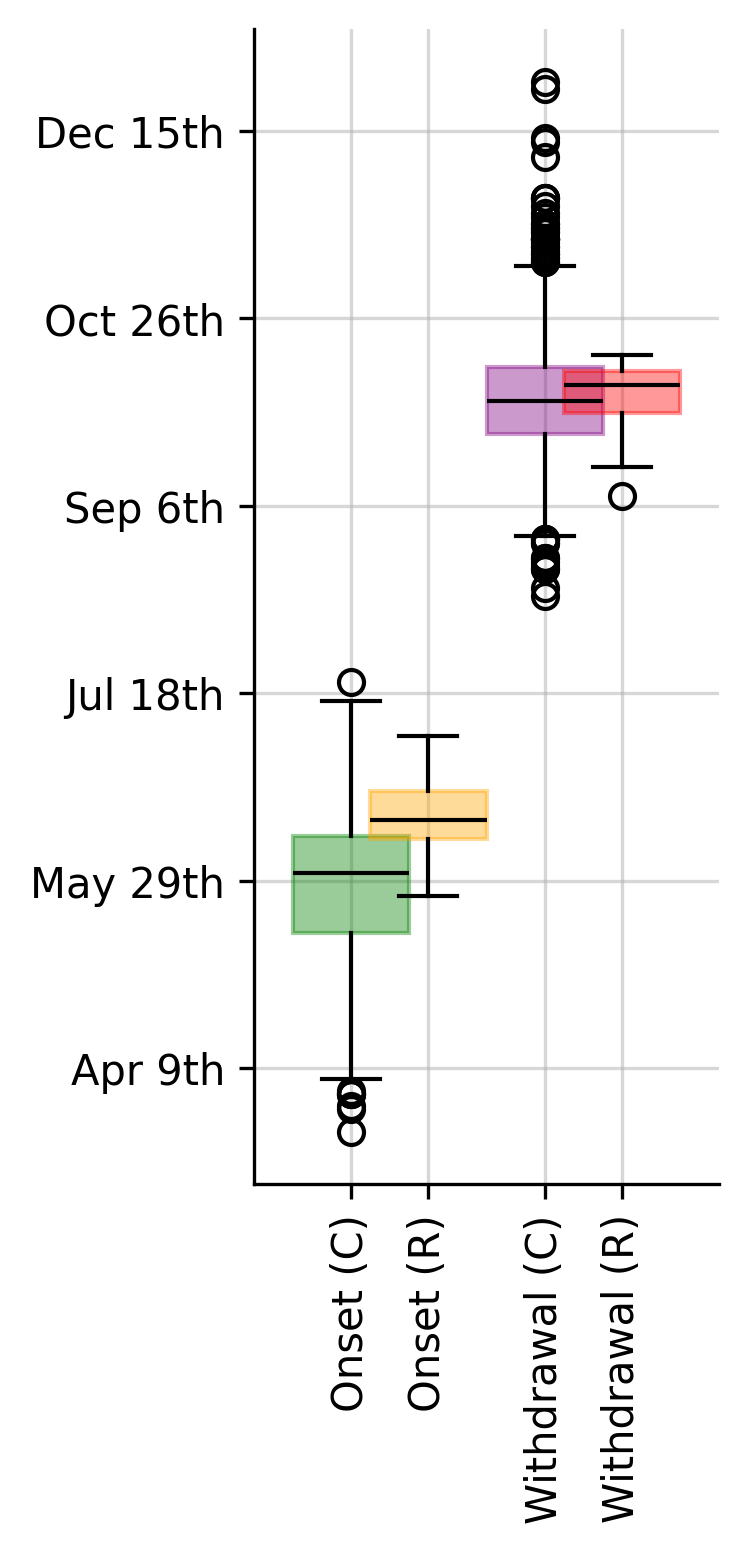

In [49]:
from visualization.custom_plots import day_of_year_to_date
fig, ax = plt.subplots(1,  1, figsize=(2, 5), dpi=300)

for k, c in zip(range(2), [['green','orange'],['purple','red']]):

    dt = clustering_results.breakpoints.isel(cluster=k).values.flatten()
    # remove nan values
    dt = dt[~np.isnan(dt)]
    # plt.hist(dt, bins=50, density=True, alpha=0.7, color=c[0])
    plt.boxplot(dt, positions=[k], widths=0.6, patch_artist=True, boxprops=dict(facecolor=c[0], color=c[0], alpha=0.4), medianprops=dict(color='black'))

    dt_ref = literature_results.isel(cluster=k).date.values.flatten()
    # remove nan values
    dt_ref = dt_ref[~np.isnan(dt_ref)]
    # plt.hist(dt_ref, bins=50, density=True, alpha=0.7, color=c[1])
    plt.boxplot(dt_ref, positions=[k + 0.4], widths=0.6, patch_artist=True, boxprops=dict(facecolor=c[1], color=c[1], alpha=0.4), medianprops=dict(color='black'))

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=0.5)
# ax.set_xlabel('Day of the year')

ax.set_yticklabels([day_of_year_to_date(int(i)) for i in ax.get_yticks()])
ax.set_xticklabels(['Onset (C)', 'Onset (R)', 'Withdrawal (C)', 'Withdrawal (R)'], rotation=90)   

In [6]:
a = clustering_results.sel(cluster=0).breakpoints
b = literature_results.sel(cluster=0).date
onset_diff = (a-b).rename('Bias').assign_coords(season_idx='onset')

a = a-a.mean()
b = b-b.mean()
onset_diff_centered = (a-b).rename('Bias').assign_coords(season_idx='onset')

a = clustering_results.sel(cluster=1).breakpoints
b = literature_results.sel(cluster=1).date
withdrawal_diff = (a-b).rename('Bias').assign_coords(season_idx='withdrawal')

a = a-a.mean()
b = b-b.mean()
withdrawal_diff_centered = (a-b).rename('Bias').assign_coords(season_idx='withdrawal')

tota = xr.concat([onset_diff,withdrawal_diff], dim='season_idx')
tota_centered = xr.concat([onset_diff_centered, withdrawal_diff_centered], dim='season_idx')

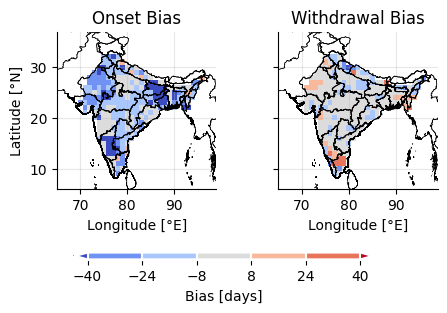

In [ ]:
plot = tota.plot(col='season_idx', col_wrap=2, vmin=-40, vmax=40, levels=6, extend='both', add_colorbar=False, figsize=(5,2.5), cmap='coolwarm')

standard_format( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

plot.axes[0][0].set_title('Onset Bias', size=12)
plot.axes[0][1].set_title('Withdrawal Bias', size=12)
plot.cbar.set_label('Bias [days]')

# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

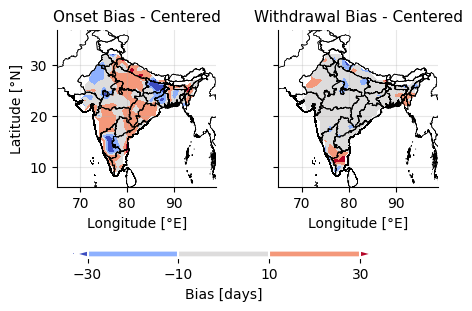

In [8]:
plot = tota_centered.plot.contourf(col='season_idx', col_wrap=2, vmin=-30, vmax=30, levels=4, add_colorbar=False, figsize=(5,2.5), cmap='coolwarm')

standard_format( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

plot.axes[0][0].set_title('Onset Bias - Centered', size=11)
plot.axes[0][1].set_title('Withdrawal Bias - Centered', size=11)
plot.cbar.set_label('Bias [days]')

# plt.savefig(results_path_image_centered, dpi=300, bbox_inches='tight', transparent=False)

In [9]:
# dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/precipitation_preprocessed.nc').tp.load().groupby('time.dayofyear').mean() * 24*1000
# dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/temperature_preprocessed.nc')['2t'].load().groupby('time.dayofyear').mean() - 273.15

In [10]:
# def region_cycle_plot(mask, name):
     
#     # Masking the dataset to remove sea points
#     dataset_tp_masked = dataset_tp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
#     dataset_tp_masked.rio.write_crs("epsg:4326", inplace=True)
#     dataset_tp_masked = dataset_tp_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

#     dataset_t2m_masked = dataset_t2m.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
#     dataset_t2m_masked.rio.write_crs("epsg:4326", inplace=True)
#     dataset_t2m_masked = dataset_t2m_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

#     clustering_result_masked = clustering_results.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
#     clustering_result_masked.rio.write_crs("epsg:4326", inplace=True)
#     clustering_result_masked = clustering_result_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

#     literature_result_masked = literature_results.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
#     literature_result_masked.rio.write_crs("epsg:4326", inplace=True)
#     literature_result_masked = literature_result_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

#     cluster_mean = clustering_result_masked.mean(['lat','lon']).__xarray_dataarray_variable__.values
#     cluster_std = clustering_result_masked.std(['lat','lon']).__xarray_dataarray_variable__.values

#     literature_mean = literature_result_masked.mean(['lat','lon']).date.values
#     literature_std = literature_result_masked.std(['lat','lon']).date.values

#     fig, ax = plt.subplots(2,2, figsize = (12, 6), gridspec_kw={'width_ratios': [1, 3]})

#     country_boundary.boundary.plot(ax = ax[0][0], color='k', lw=0.2)
#     mask.boundary.plot(ax = ax[0][0], color='red', lw=1)
#     mask.plot(ax = ax[0][0], color='red')
#     ax[0][0].set_ylabel('Latitude [°N]')
#     ax[0][0].set_xlabel('Longitude [°E]')


#     dataset_tp_masked.quantile(0.5,['lat','lon']).plot(ax=ax[0][1], lw = 2, c = 'darkgreen', label='Spatial median')
#     dataset_tp_masked.quantile(0.90,['lat','lon']).plot(ax=ax[0][1], lw = 1, c = 'darkblue', label='Spatial 90th percentile')
#     dataset_tp_masked.quantile(0.10,['lat','lon']).plot(ax=ax[0][1], lw = 1, c = 'darkred', label='Spatial 10th percentile')

#     dataset_t2m_masked.quantile(0.5,['lat','lon']).plot(ax=ax[1][1], lw = 2, c = 'darkgreen', label='Spatial median')
#     dataset_t2m_masked.quantile(0.90,['lat','lon']).plot(ax=ax[1][1], lw = 1, c = 'darkblue', label='Spatial 90th percentile')
#     dataset_t2m_masked.quantile(0.10,['lat','lon']).plot(ax=ax[1][1], lw = 1, c = 'darkred', label='Spatial 10th percentile')

#     ax[0][1].plot([0],[0], label=' ', c='none')
    
#     ax[0][1].axvline(literature_mean[0], color='k', linestyle='--', label='Literature - avg')
#     ax[0][1].axvspan(literature_mean[0] - literature_std[0], literature_mean[0] + literature_std[0], alpha=0.8, color='gray', label='Literature - std')
#     ax[1][1].axvline(literature_mean[0], color='k', linestyle='--')
#     ax[1][1].axvspan(literature_mean[0] - literature_std[0], literature_mean[0] + literature_std[0], alpha=0.8, color='gray')


#     ax[0][1].axvline(literature_mean[1], color='k', linestyle='--')
#     ax[0][1].axvspan(literature_mean[1] - literature_std[1], literature_mean[1] + literature_std[1], alpha=0.8, color='gray')
#     ax[1][1].axvline(literature_mean[1], color='k', linestyle='--')
#     ax[1][1].axvspan(literature_mean[1] - literature_std[1], literature_mean[1] + literature_std[1], alpha=0.8, color='gray')

#     ax[0][1].axvline(cluster_mean[0], color='r', label='Clustering - avg')
#     ax[0][1].axvspan(cluster_mean[0] - cluster_std[0], cluster_mean[0] + cluster_std[0], alpha=0.2, color='red', label='Clustering - std')
#     ax[1][1].axvline(cluster_mean[0], color='r')
#     ax[1][1].axvspan(cluster_mean[0] - cluster_std[0], cluster_mean[0] + cluster_std[0], alpha=0.2, color='red')

#     ax[0][1].axvline(cluster_mean[1], color='r')
#     ax[0][1].axvspan(cluster_mean[1] - cluster_std[1], cluster_mean[1] + cluster_std[1], alpha=0.2, color='red')
#     ax[1][1].axvline(cluster_mean[1], color='r')
#     ax[1][1].axvspan(cluster_mean[1] - cluster_std[1], cluster_mean[1] + cluster_std[1], alpha=0.2, color='red')

#     ax[0][1].legend(ncol=1, loc='upper right', fancybox=True, bbox_to_anchor=(1.34, 0.1))

#     for ax_s in ax.ravel():
#         ax_s.grid()
#         ax_s.spines['top'].set_visible(False)
#         ax_s.spines['right'].set_visible(False)
    


#     ax[0][1].set_title('')
#     ax[0][1].set_ylabel('[mm/day]')

#     ax[1][1].set_title('')
#     ax[1][1].set_ylabel('[°C]')
    
#     ax[1][1].set_xlabel('Month')
#     ax[0][1].set_xlabel('')
#     ax[0][1].set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
#     ax[1][1].set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
#     fig.suptitle(name)

#     ax[1][0].axis('off')


#     return fig


In [11]:
# # for country_name in np.unique(country_boundary.NAME_1):

# #     try:

# #         mask = country_boundary[country_boundary.NAME_1 == country_name]
# #         fig  = region_cycle_plot(mask, country_name)
# #         fig.savefig(f'../data/results/images/cycles/{country_name}.png', dpi=300, bbox_inches='tight', transparent=False)

# #     except:
# #         pass


# fig = region_cycle_plot(world_boundary[world_boundary.COUNTRY=='Bangladesh'], 'Bangladesh')
# fig.savefig(f'../data/results/images/cycles/Bangladesh.png', dpi=300, bbox_inches='tight', transparent=False)

# fig = region_cycle_plot(world_boundary[world_boundary.COUNTRY=='Nepal'], 'Nepal')
# fig.savefig(f'../data/results/images/cycles/Nepal.png', dpi=300, bbox_inches='tight', transparent=False)